# LDDMM: how to estimate a deterministic atlas?

In [7]:
from pathlib import Path

import pyvista as pv
from in_out.array_readers_and_writers import read_3D_array

import polpo.lddmm as lddmm
import polpo.lddmm.strings as lddmm_strings
from polpo.preprocessing import (
    Map,
    PartiallyInitializedStep,
)
from polpo.preprocessing.load.pregnancy import (
    DenseMaternalMeshLoader,
)
from polpo.preprocessing.mesh.io import PvReader, PvWriter
from polpo.preprocessing.mesh.registration import PvAlign

In [8]:
VIZ = False
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

In [9]:
OUTPUTS_DIR = Path("results") / "atlas_example"
ATLAS_DIR = OUTPUTS_DIR / "atlas"

OUTPUTS_DIR.mkdir(exist_ok=True)

## Loading meshes

In [10]:
subject_id = "01"

file_finder = DenseMaternalMeshLoader(
    subject_id=subject_id,
    # subset=[1, 2, 3],
    as_dict=False,
    left=True,
    struct="Hipp",
)

pipe = file_finder + Map(PvReader())

meshes = pipe()

In [11]:
if VIZ:
    pl = pv.Plotter(border=False)

    for mesh in meshes:
        pl.add_mesh(mesh, show_edges=True)

    pl.show()

In [12]:
prep_pipe = PartiallyInitializedStep(
    Step=lambda **kwargs: Map(PvAlign(**kwargs)),
    _target=lambda meshes: meshes[0],
    max_iterations=500,
)

meshes = prep_pipe(meshes)

In [13]:
if VIZ:
    pl = pv.Plotter(border=False)

    for mesh in meshes:
        pl.add_mesh(mesh, show_edges=True)

    pl.show()

## LDDMM

Save meshes in `vtk` format (as required by `deformetrica`).

In [14]:
meshes_writer = Map(PvWriter(dirname=OUTPUTS_DIR, ext="vtk"))

mesh_filenames = meshes_writer(
    [(f"mesh_{index}", mesh) for index, mesh in enumerate(meshes)]
)

Use LDDMM to estimate the atlas.

In [15]:
dataset = [{"shape": filename} for filename in mesh_filenames]

In [16]:
kernel_width = 10  # NB: influences the number of cp
registration_kwargs = dict(
    kernel_width=kernel_width,
    regularisation=1,
    max_iter=2000,
    freeze_control_points=False,
    metric="varifold",
    attachment_kernel_width=2.0,
    tol=1e-10,
    # filter_cp=True,
    # threshold=0.75,
)


lddmm.estimate_deterministic_atlas(
    dataset[0]["shape"],
    dataset,
    "structure",
    ATLAS_DIR,
    initial_step_size=1e-1,
    **registration_kwargs,
)

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 10
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/atlas_example/atlas/deformetrica-state.p.
>> Removing the pre-existing state file with same path.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
{'max_iterations': 2000, 'freeze_template': False, 'freeze_control_points': False, 'freeze_momenta': False, 'use_sobolev_gradient': True, 'sobolev_kernel_width_ratio': 1, 'max_line_search_iterations': 50, 'initial_control_points': None, 'initial_cp_spacing': None, 'initial_momenta': None, 'dense_mode': False, 'number_of_threads': 1, 'print_every_n_iters': 20, 'downsampling_factor': 1, 'dimension': 3, 'optimization_method

In [19]:
cp = read_3D_array(ATLAS_DIR / lddmm_strings.cp_str)
momenta = read_3D_array(ATLAS_DIR / lddmm_strings.momenta_str)

template = PvReader()(ATLAS_DIR / lddmm_strings.template_str)

In [21]:
momenta.shape

(27, 24, 3)

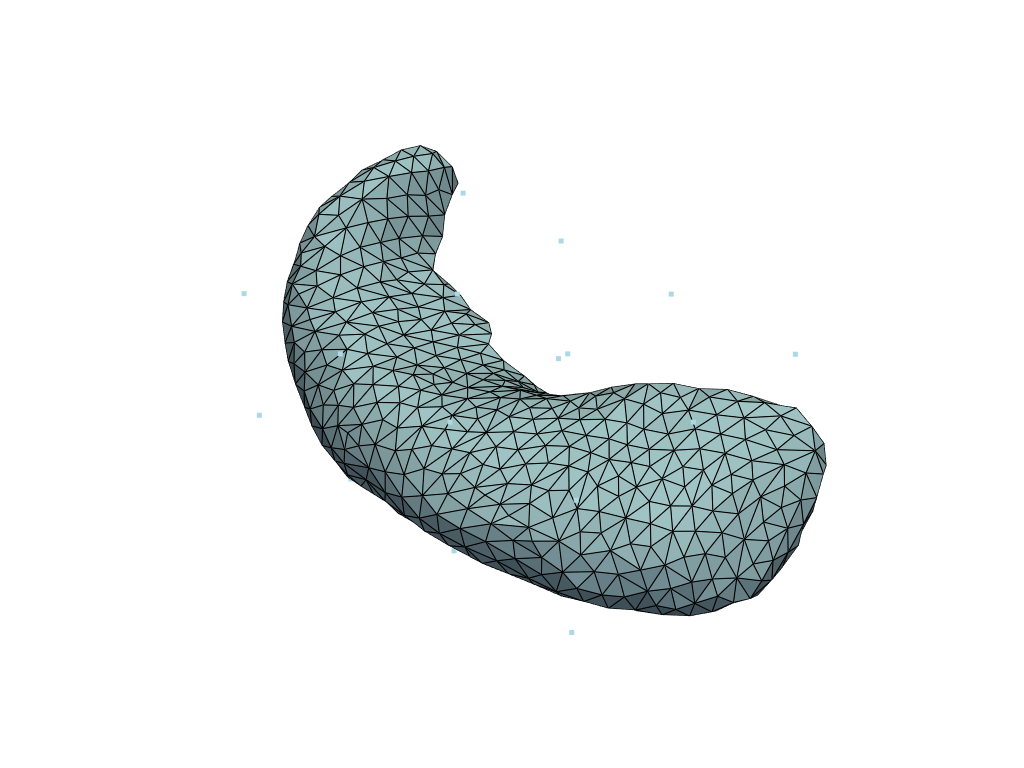

In [20]:
pl = pv.Plotter()

pl.add_mesh(template, show_edges=True)

pl.add_mesh(pv.PolyData(cp))

pl.show()

TODO: shoot for everything